In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as f
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt 
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


In [2]:
data = pd.read_csv('mnist_train.csv')
data = data.values
labels = data[:, 0]
data = data[:,1:]

print(labels.shape)
print(data.shape)

(20000,)
(20000, 784)


In [4]:
# step 1 : convert to tensor 
dataT = torch.tensor(data).float()
labels = torch.tensor(labels).long()

# step 2 : splitting the data 
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labels, test_size = .1)

# step 3 : convert tensor datasets 
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels) 

# step 4 : dataloaders 
train_loader = DataLoader(train_data, batch_size = 32)
test_loader = DataLoader(test_data, batch_size = len(test_data))

In [7]:
train_loader.dataset.tensors[0]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

Text(0.5, 1.0, 'Shift (rolled)')

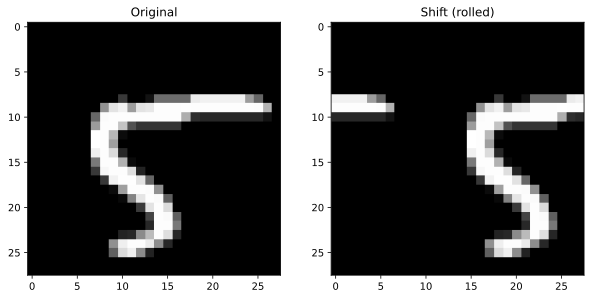

In [29]:
# grab one image data 
tmp = test_loader.dataset.tensors[0][0, :]
tmp = tmp.reshape(28,28)

# shift image 
tmpS = torch.roll(tmp, 8, dims = 1)

# now show them both 
fig, ax = plt.subplots(1,2, figsize =(10, 6))

ax[0].imshow(tmp, cmap = 'gray')
ax[0].set_title('Original')

ax[1].imshow(tmpS, cmap = 'gray')
ax[1].set_title('Shift (rolled)')



In [28]:
# now repeating this for all images in testset 

for i in range(test_loader.dataset.tensors[0].shape[0]):

    # get the image 
    img = test_loader.dataset.tensors[0][i, :]

    # reshape 
    randroll = np.random.randint(-10, 11)
    img = torch.roll(img.reshape(28, 28), randroll, dims = 1)

    # re-vectorize and put back into the matrix 
    test_loader.dataset.tensors[0][i,:] = img.reshape(1,-1)

In [30]:
 def createTheMNISTNet():

    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()
            

            # input layer 
            self.input = nn.Linear(784, 64)

            # hidden layers
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)

            # output layer 
            self.output = nn.Linear(32, 10)

        def forward(self, X):
            
            X = f.relu(self.input(X))
            X = f.relu(self.fc1(X))
            X = f.relu(self.fc2(X))

            return self.output(X)
        
    # create the model instance 
    net = mnistNet()

    # loss function 
    lossfun = nn.CrossEntropyLoss()

    # optimizer 
    optimizer = torch.optim.SGD(net.parameters(), lr = .01)

    return net, lossfun, optimizer 



            
            

In [31]:
def function2trainTheModel():

    # number of epochs 
    numepochs = 100

    # create a new model 
    net, lossfun, optimizer = createTheMNISTNet()

    # losses 
    losses = np.zeros(numepochs)
    trainAcc = []
    testAcc = []


    for epochi in range(numepochs):
        net.train()
        batchAcc = []
        batchLoss = []

        for X, y in train_loader:

            yHat = net(X)
            loss = lossfun(yHat, y)
            batchLoss.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # matches 
            matches = (torch.argmax(yHat, axis = 1) == y ).float()
            accuracypct = 100*torch.mean(matches)
            batchAcc.append(accuracypct)
        
        losses[epochi] = np.mean(batchLoss)
        trainAcc.append(np.mean(batchAcc))

        net.eval()
        X, y = next(iter(test_loader))
        with torch.inference_mode():
            yHat = net(X)
            loss = lossfun(yHat, y)
            matches = (torch.argmax(yHat, axis = 1) == y ).float()
            accuracypct = 100*torch.mean(matches)
            testAcc.append(accuracypct)

    return trainAcc, testAcc, losses, net


In [32]:
trainAcc, testAcc, losses, net = function2trainTheModel()

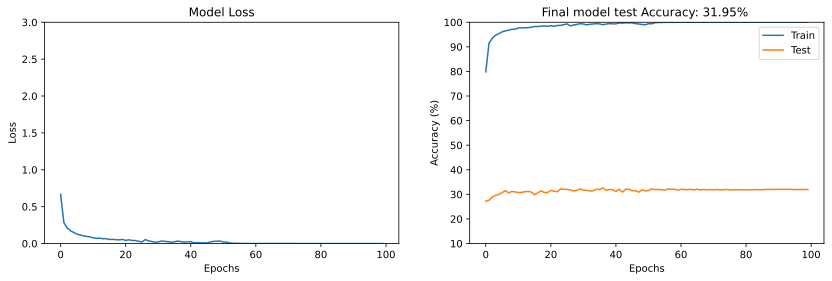

In [33]:
fig, ax = plt.subplots(1,2, figsize = (14,4))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model Loss')

ax[1].plot(trainAcc, label = 'Train')
ax[1].plot(testAcc, label = 'Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test Accuracy: {testAcc[-1]:.2f}% ')
ax[1].legend()

plt.show()